# Lorenz

In [72]:
import pickle
import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt
import networkx as nx
from tvregdiff import TVRegDiff
import seaborn as sns


def remove_diag(A):
    return A[~np.eye(A.shape[0], dtype=bool)].flatten()


def mesh_grid(x, y):
    xx = np.tile(x, (y.shape[0], 1))
    yy = np.tile(y[:, np.newaxis], (1, x.shape[0]))
    return xx, yy


# %% Load dataset
with open('raw/lorenz96_conditional_SVM_wilcoxon_stats.pkl', 'rb') as f:
    SVM = pickle.load(f)
with open('raw/lorenz96_conditional_LSTM_L2_0.01_wilcoxon_stats.pkl', 'rb') as f:
    LSTM_L2 = pickle.load(f)
with open('raw/lorenz96_conditional_MLP_L2_0.1_wilcoxon_stats.pkl', 'rb') as f:
    MLP_L2 = pickle.load(f)
with open('raw/lorenz96_truth.pkl', 'rb') as f:
    ground_truth = pickle.load(f)
p = np.stack([SVM['p_val'], LSTM_L2['p_val'], MLP_L2['p_val']], axis=2)
n = p.shape[0]
k = p.shape[2]
assert n == p.shape[1], 'P-values matrix should be square.'
pred_truth = remove_diag(ground_truth)


# %% Model independence coefficient curve
@np.vectorize
def mic_connectivity(c_, alpha_):
    chi_ = -2 * np.sum(np.log(p), axis=2) * c_
    pred = chi2.cdf(chi_, df=2 * k) > 1 - alpha_  # diagonal are all False
    g = nx.DiGraph()
    g.add_edges_from(zip(*np.where(pred)))
    if len(g.nodes) == 0:
        return 0
    return nx.node_connectivity(g)


c = np.linspace(0, 1, 26)
alpha = np.array([0.01, 0.05, 0.1])
alpha_grid, c_grid = mesh_grid(alpha, c)
connectivity = mic_connectivity(c_grid, alpha_grid)
fig, ax = plt.subplots(figsize=(3.75, 3))
best_c = np.zeros(shape=alpha.shape)
for j in range(alpha.shape[0]):
    diff_1 = TVRegDiff(connectivity[:, j], itern=1, alph=0.5, plotflag=False)
    b = np.argmax(diff_1)
    ax.plot(c, diff_1, label=f'alpha = {alpha[j]}')
    ax.scatter(c[b], diff_1[b], marker='x')
    best_c[j] = c[b]
    ax.annotate(f'c={round(c[b], 2)}', (c[b], diff_1[b]))
ax.legend()
fig.subplots_adjust(bottom=0.15, left=0.2, right=0.98, top=0.98)
ax.set_xlabel('Model independence coefficient (c)')
ax.set_ylabel('Derivative of node connectivity')
fig.savefig('results/lorenz96_chisq_multiplier.eps')
plt.close(fig)


# %% Export the result (alpha = 0.01)
@np.vectorize
def decimal_non_zero(x):
    return format(x, '.2f').lstrip('0')


c0 = best_c[0]
chi0 = -2 * np.sum(np.log(p), axis=2) * c0
p0 = 1 - chi2.cdf(chi0, df=2 * k)
with open('raw/lorenz96_combined_chisq_p.pkl', 'wb') as f:
    pickle.dump({'p': p0, 'c': c0}, f)

fig, ax = plt.subplots(figsize=(5, 4))
mask = np.zeros_like(p0, dtype=bool)
mask[np.diag_indices_from(mask)] = True
heatmap = sns.heatmap(p0, mask=mask, square=True, linewidths=.5, cmap='coolwarm',
                      vmin=0, vmax=0.1, annot=decimal_non_zero(p0), fmt='')
ax.set_ylabel('Cause')
ax.set_xlabel('Effect')
fig.subplots_adjust(bottom=0.15, top=0.95)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})
heatmap.get_figure().savefig('results/lorenz96_combined_chisq.eps')
plt.close(fig)


Text(0, 0.5, 'Derivative of node connectivity')

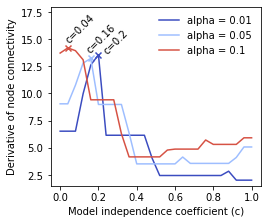

In [73]:
import matplotlib
cmap = matplotlib.cm.get_cmap('coolwarm')
mycolors = [cmap(0), cmap(0.3), cmap(0.9)]

fig, ax = plt.subplots(figsize=(3.75, 3))
best_c = np.zeros(shape=alpha.shape)
for j in range(alpha.shape[0]):
    diff_1 = TVRegDiff(connectivity[:, j], itern=1, alph=0.5, plotflag=False)
    b = np.argmax(diff_1)
    ax.plot(c, diff_1, label=f'alpha = {alpha[j]}', c=mycolors[j])
    ax.scatter(c[b], diff_1[b], marker='x', color=mycolors[j])
    best_c[j] = c[b]
    ax.annotate(f'c={round(c[b], 2)}', (c[b]-np.array([-0.02,0.03,0.02])[j], diff_1[b]+np.array([0.1,0.5,0.5])[j]), rotation=45)
ax.legend(frameon=False)
ax.set_ylim([1.5, 18])
fig.subplots_adjust(bottom=0.15, left=0.2, right=0.98, top=0.98)
ax.set_xlabel('Model independence coefficient (c)')
ax.set_ylabel('Derivative of node connectivity')

In [74]:
fig.savefig('results/lorenz96_chisq_multiplier.pdf')

# Stock Market

Text(0, 0.5, 'Derivative of node connectivity')

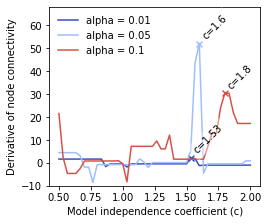

In [70]:
fig, ax = plt.subplots(figsize=(3.75, 3))
best_c = np.zeros(shape=alpha.shape)
for j in range(alpha.shape[0]):
    diff_1 = TVRegDiff(connectivity[:, j], itern=1, alph=1, plotflag=False)
    b = np.argmax(diff_1)
    ax.plot(c, diff_1, label=f'alpha = {alpha[j]}', c=mycolors[j])
    ax.scatter(c[b], diff_1[b], marker='x', color=mycolors[j])
    best_c[j] = c[b]
    #ax.annotate(f'c={round(c[b], 2)}', (c[b]+0.01, diff_1[b]+2), rotation=45, backgroundcolor='w')
    plt.text(c[b]+0.01, diff_1[b]+2, f'c={round(c[b], 2)}', bbox=dict(facecolor='w', alpha=0.4, edgecolor='none'), rotation=45)
ax.legend(frameon=False)
ax.set_ylim([-10, 68])
fig.subplots_adjust(bottom=0.15, left=0.2, right=0.98, top=0.98)
ax.set_xlabel('Model independence coefficient (c)')
ax.set_ylabel('Derivative of node connectivity')

In [71]:
fig.savefig('results/indices_chisq_multiplier.pdf')